In [72]:
import pandas as pd
from dotenv import load_dotenv
import os

from sqlalchemy import create_engine
from sqlalchemy import text

from matplotlib import pyplot as plt
load_dotenv()

user = os.environ.get("DB_USERNAME")
password = os.environ.get("DB_PASSWORD")
hostname = os.environ.get("DB_HOST")
database_name =  os.environ.get("DB_NAME")
port = os.environ.get("DB_PORT")
cluster = os.environ.get("DB_CLUSTER")
youtube_api_key = os.environ.get("YOUTUBE_API_KEY")

engine = create_engine(f'cockroachdb://{user}:{password}@{hostname}:{port}/{database_name}?sslmode=require&options=--cluster={cluster}')

In [73]:
conn = engine.connect()
df = pd.read_sql("""SELECT vvl.* FROM video_view_lifecycle vvl
                    JOIN video_notification_feed vnf ON vvl.video_id = vnf.video_id
                    where vnf.record_timestamp > '2022-06-21 07:00:00.00' 
                    and vnf.video_id in ('ofE31H1hsfc')
                    ORDER BY vvl.video_id desc, vvl.record_timestamp asc""", 
                conn)

In [74]:
df.head(5)

,video_id,video_title,channel_id,channel_name,views,likes,favorites,comment_count,dislikes,video_duration,thumbnail_url,date_uploaded,record_timestamp
0,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,0,90,0,8,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:11:26.922250
1,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,0,90,0,8,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:11:26.922250
2,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,0,90,0,8,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:11:26.922250
3,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,362,161,0,22,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:12:29.558294
4,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,362,161,0,22,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:12:29.558294


In [75]:
def calc_timedetlas(row):
    return pd.Timedelta(row["record_timestamp"] - df[df["video_id"] == row["video_id"]].iloc[0]["date_uploaded"], unit='seconds').total_seconds() / 60

def calc_percentage_deltas(row):
    return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1

df["time_delta"] = df.apply(calc_timedetlas, axis=1)
df["view_delta"] = df.groupby(['video_id'])['views'].diff().fillna(0)
df["view_percentage_delta"] = df.apply(calc_percentage_deltas, axis=1)
df = df.drop_duplicates(subset=['time_delta'])

df.head(3)

/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1205/3742548750.py:5: RuntimeWarning: invalid value encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1
/var/folders/0z/7vw3n45915b9fwdtfny4prlh0000gn/T/ipykernel_1205/3742548750.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  return row["views"] / df[df["video_id"] == row["video_id"]].iloc[0]["views"] - 1


,video_id,video_title,channel_id,channel_name,views,likes,favorites,comment_count,dislikes,video_duration,thumbnail_url,date_uploaded,record_timestamp,time_delta,view_delta,view_percentage_delta
0,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,0,90,0,8,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:11:26.922250,0.798704,0.0,NaN
3,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,362,161,0,22,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:12:29.558294,1.842638,362.0,inf
6,ofE31H1hsfc,G FUEL Fired Him for Speaking Out,UCjK0F1DopxQ5U0sCwOlXwOg,Mogul Mail,772,241,0,29,-1,PT7M6S,https://i.ytimg.com/vi/ofE31H1hsfc/default.jpg,2022-06-24 00:10:39,2022-06-24 00:13:30.592574,2.859876,410.0,inf


In [76]:
# channel_ids = ['UCq6VFHwMzcMXbuKyG7SQYIg', 'UCz6XquIbM5OcfK7r3hQQCXA']
# channel_df = df[df["channel_id"].isin(channel_ids)]
# channel_df['video_id'].nunique()
# channel_df[channel_df['video_id']=='qb4jMvGdOTw']


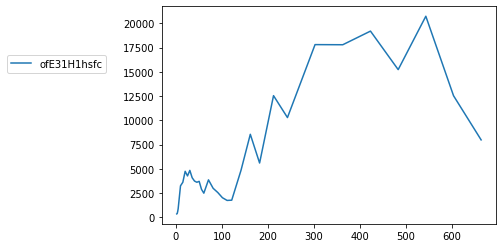

In [77]:
for video_id in set(df['video_id'].to_list()):
    video_df = df[df["video_id"] == video_id]
    video_df = video_df[video_df['time_delta'] < 60 * 12]
    video_df = video_df[video_df['view_delta'] > 0]
    plt.plot(video_df.time_delta, video_df.view_delta, label=video_id)
plt.legend(bbox_to_anchor=(-.15,.8))
plt.show()


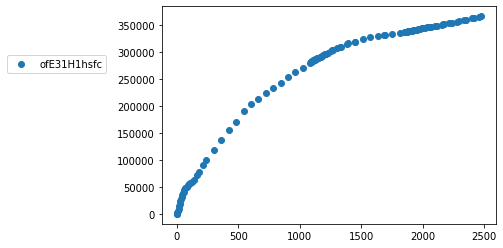

In [78]:
for video_id in set(df['video_id'].to_list()):
    video_df = df[df["video_id"] == video_id]
    video_df = video_df[video_df['time_delta'] < 2500]
    plt.scatter(video_df.time_delta, video_df.views, label=video_id)
plt.legend(bbox_to_anchor=(-.15,.8))
plt.show()

R squared value of 0.9906750513304802 from fitted curve


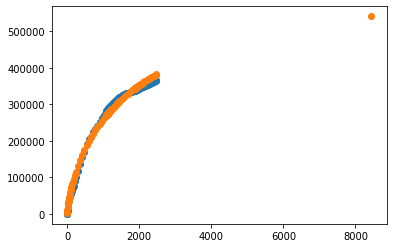

In [82]:
from scipy.optimize import curve_fit
import numpy as np

def predict(x, a, b, c):
    return a * x ** c  / (x ** c + b)

for i in range(1, df.time_delta.to_list()):
    x_data = df.time_delta.to_list()[:i]
    y_data = df.views.to_list()[:i]
    param, param_cov = curve_fit(predict, x_data, y_data)

    y_pred = predict(df.time_delta, *param)
    residuals = residuals = df.views- predict(df.time_delta, *param)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((df.views-np.mean(df.views))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f"R squared value of {r_squared} from fitted curve")

    plt.scatter(video_df.time_delta, video_df.views, label=video_id)
    plt.scatter(df.time_delta, y_pred, label=video_id)
    plt.show()



In [83]:
param

array([7.44138235e+05, 3.44398792e+02, 7.54550932e-01])